<a href="https://colab.research.google.com/github/hongsy0113/cose461-NLP-project-choi-hong/blob/main/lstm_%EB%94%B0%EB%9D%BC%ED%95%98%EA%B8%B02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install soynlp
!pip install konlpy
from soynlp.normalizer import *
import soynlp




     |████████████████████████████████| 416 kB 5.2 MB/s 
     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 448 kB 72.4 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [3]:

import json
from pandas import json_normalize

import torch
from torch import nn

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
# json data 파일들을 google drive에 저장
# google drive 에 있는 파일들을 접근하기 위해 mount
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#위에서의 json2df 함수 수정함
def json2df (file):
  with open(file, 'r') as f:
    jdata = json.load(f)
  
  meta_list = [['header', 'dialogueInfo', 'numberOfParticipants'],
             ['header', 'dialogueInfo', 'numberOfUtterances'],
             ['header', 'dialogueInfo', 'dialogueID'],
            ]
  # dataframe of utterances 
  df1 = pd.json_normalize(jdata['data'][:], record_path=['body'], meta= meta_list, errors='ignore')
  # dataframe of participants info
  df2 = pd.json_normalize(jdata['data'], record_path=['header', 'participantsInfo'],  meta= [['header', 'dialogueInfo', 'dialogueID']], errors='ignore')
  # join df1 and df2 where (df1.dialogueID == df2.dialogueID and df1.participantID == df2.participantID)
  df = pd.merge(left = df1 , right = df2, how = "left", on = ["header.dialogueInfo.dialogueID", 'participantID' ],sort=False)

  # rename column names
  # 열이름 너무 길어서 바꿈. P는 참가자, U는 메시지, D는 대화, T는 turn 으로 통일시킴. 맘에 안 들면 바꿔도 ok
  df.rename(columns = {'header.dialogueInfo.numberOfParticipants' : 'P_num', 
                       'header.dialogueInfo.numberOfUtterances': 'U_num', 
                       'header.dialogueInfo.dialogueID':'D_id',
                       'utteranceID':'U_id',
                       'participantID':'P_id',
                       'gender':'P_gender',
                       'age':'P_age'}, inplace = True)

  df= df[['utterance', 'U_id', 'P_id', 'P_num', 'D_id', 'P_gender']]

  # 대화 id 를 0부터 일련번호로 변경
  D_id_list = []

  num = -1 
  current = None
  for id in df['D_id']:
    if id != current:
      num +=1
      current = id
    D_id_list.append(num)

  df['D_id'] = D_id_list

  return df


# 행사.json, 식음료.json 등 여러 데이터셋을 하나로 만들기 위한 함수
def concat_json2df (file_list):
  result = None

  for i, file in enumerate(file_list):
    df = json2df(file)
    if (i==0):
      result = df.copy()
    else:
      result = pd.concat([result,df])
  return result

In [220]:
f_list = ['/content/gdrive/MyDrive/cose461/일과직업.json']

raw_df = concat_json2df(f_list)


raw_df.head(20)

,utterance,U_id,P_id,P_num,D_id,P_gender
0,여러 명 같이 하나보네?,U1,P01,2,0,여성
1,#@이모티콘#,U2,P01,2,0,여성
2,응 한 10명?,U3,P02,2,0,여성
3,프로그램 다운이 안 됐대,U4,P02,2,0,여성
4,아,U5,P01,2,0,여성
5,강제로 쉬는 시간,U6,P01,2,0,여성
6,평일엥 일하겠네 우리 #@이름#,U7,P01,2,0,여성
7,평일엔...,U8,P01,2,0,여성
8,다음 주부터는,U9,P02,2,0,여성
9,바쁘겠다,U10,P02,2,0,여성


In [221]:
df = raw_df.copy()

# 1. lstm 모델

https://wikidocs.net/44249 
이 내용 거의 따라함

 lstm 모델 따라하기 2 의 아이디어
- 같은 화자의 데이터는 하나의 덩어리로 처리하도록

In [222]:
# Naive-Bayes Method.
#df = df[['utterance', 'P_gender']]
df['P_gender'].value_counts()

여성    970761
남성    195332
Name: P_gender, dtype: int64

In [223]:
# Gender to discrete variable
# 0 : '여성', 1 : '남성'
df['P_gender'] = [0 if gender=='여성' else 1 for gender in df['P_gender']]
df = df.set_index(['D_id','P_id'] )

In [224]:
df = df.sort_index()
df['index'] = df.index
df.head(5)

utterance U_id P_num  P_gender     index
D_id P_id                                                  
0    P01       여러 명 같이 하나보네?   U1     2         0  (0, P01)
     P01             #@이모티콘#   U2     2         0  (0, P01)
     P01                   아   U5     2         0  (0, P01)
     P01           강제로 쉬는 시간   U6     2         0  (0, P01)
     P01   평일엥 일하겠네 우리 #@이름#   U7     2         0  (0, P01)

In [225]:
s = df.groupby(df.index)['utterance'].apply(' '.join).to_frame()

s.head(15)

,utterance
"(0, P01)",여러 명 같이 하나보네? #@이모티콘# 아 강제로 쉬는 시간 평일엥 일하겠네 우리 ...
"(0, P02)",응 한 10명? 프로그램 다운이 안 됐대 다음 주부터는 바쁘겠다
"(1, P01)",그래도 스케줄은 그지같이 안짤거 아니야 #@이모티콘# ㅋㅋㅋㅋ 이제 쓸 연차도 없지...
"(1, P02)",전 정말 웃음이 안나요 그게 다행이져 ㅋㅋㅋㅋㅋㅋㅋ 내 연차 함부로 안써줬으면 좋겠...
"(2, P01)",근데 만약에 남성이 결혼을 안한다면 기혼자와 미혼자 간의 휴가 차이가 발생하지 않을...
"(2, P02)",응 그렇겠지 미혼자들이 아무래도 불공평하다고 느낄거야 아니면 미혼자만을 위한 휴가를...
"(3, P01)",헐쌤 그럼 내가 전화해본거 아실꺼 아니야ㅠㅠ 나 이상하게 보겠어ㅠㅠ ㅠㅠ나 안 그래...
"(3, P02)",아니 그건 아님 #@이름#이 전화한거 아셔 긍까 낼 어린이집 방학 얘기 하지마 낼 ...
"(4, P01)","추석 앞앞 날부터 3일쉬고! ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 대신 오늘 쉽니다,, 어냐아녀 ..."
"(4, P02)",아이고야.... 추석때도 그럼 일했겠네.. 아 연달아 쉰다는 소리로 착각함..


In [226]:
df = pd.merge(left = s.reset_index(), right = df[['P_gender','index']], how = "left", left_on=['index'], right_on= ['index'], sort=False).drop_duplicates().set_index('index').reset_index()
df

,index,utterance,P_gender
0,"(0, P01)",여러 명 같이 하나보네? #@이모티콘# 아 강제로 쉬는 시간 평일엥 일하겠네 우리 ...,0
1,"(0, P02)",응 한 10명? 프로그램 다운이 안 됐대 다음 주부터는 바쁘겠다,0
2,"(1, P01)",그래도 스케줄은 그지같이 안짤거 아니야 #@이모티콘# ㅋㅋㅋㅋ 이제 쓸 연차도 없지...,0
3,"(1, P02)",전 정말 웃음이 안나요 그게 다행이져 ㅋㅋㅋㅋㅋㅋㅋ 내 연차 함부로 안써줬으면 좋겠...,0
4,"(2, P01)",근데 만약에 남성이 결혼을 안한다면 기혼자와 미혼자 간의 휴가 차이가 발생하지 않을...,1
...,...,...,...
164409,"(76197, P04)",펜트하우스 보는데 홀린듯 계속보게되네 지금 보고잇는데 엄마 옆에서 계속 스포하는 중이다ㅠ,0
164410,"(76198, P01)",ㅋㅋㅋㅋㅋㅋ 사이버 대학이라 바뀌는게 없다 ㅋㅋㅋ 딴데도 찾아봐 헐랭 여자라 그런가...,1
164411,"(76198, P02)",ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 난 내일도 쿠팡 되길... 마켓컬리 두번 지원했는데 두번다 ...,0
164412,"(76199, P01)",남자부사수 생기는데~ 이게 하렘아니고 뭐노 너 빠른이니까 무시하지말라해 정정합니다 ...,0


In [227]:
from soynlp.tokenizer import RegexTokenizer
from soynlp.normalizer import *

tokenizer = RegexTokenizer()

In [165]:
# 실행 안 해도 됨
"""
# soynlp 의 repeat_normalzie 함수
# 반복되는 글자들을 num_repeat 수 만큼 통일시킨다.
# 그냥 이 함수를 쓸까 하다가 다 똑같이 통일하면 의미를 온전히 표현 못할 수도 있을거 같아서 나중에 필요하면 ㅋㅋㅋ 개수를 threshold를 기준으로 분류하든지

def repeat_normalize(sent, num_repeats=2):
    if num_repeats > 0:
        sent = soynlp.repeatchars_pattern.sub('\\1' * num_repeats, sent)
    sent = doublespace_pattern.sub(' ', sent)
    return sent.strip()
"""
def my_repeat_normalize(sent, num_repeats=2):
    if num_repeats > 0:
        sent = soynlp.repeatchars_pattern.sub('\\1' * num_repeats, sent)
    sent = doublespace_pattern.sub(' ', sent)
    return sent.strip()


In [228]:
# soynlp 설명 참고 링크
#https://github.com/lovit/soynlp
# df['utterance'] 에서 ㅋㅋㅋㅋㅋ와 같이 반복되는 글지 normalize 하고 tokenize

def text_normalize(sent):
  #result= emoticon_normalize(sent, num_repeats= 2)
  result = tokenizer.tokenize(sent)
  for i, token in enumerate(result):  
    tmp = emoticon_normalize(token, num_repeats= 2)
    result[i] = repeat_normalize(tmp, num_repeats=1)
    #result[i] = tmp
    pass
  return result

df['sents'] = df['utterance'].apply(text_normalize)
df.head(10)

,index,utterance,P_gender,sents
0,"(0, P01)",여러 명 같이 하나보네? #@이모티콘# 아 강제로 쉬는 시간 평일엥 일하겠네 우리 ...,0,"[여러, 명, 같이, 하나보네, ?, #@, 이모티콘, #, 아, 강제로, 쉬는, ..."
1,"(0, P02)",응 한 10명? 프로그램 다운이 안 됐대 다음 주부터는 바쁘겠다,0,"[응, 한, 10, 명, ?, 프로그램, 다운이, 안, 됐대, 다음, 주부터는, 바..."
2,"(1, P01)",그래도 스케줄은 그지같이 안짤거 아니야 #@이모티콘# ㅋㅋㅋㅋ 이제 쓸 연차도 없지...,0,"[그래도, 스케줄은, 그지같이, 안짤거, 아니야, #@, 이모티콘, #, ㅋㅋ, 이..."
3,"(1, P02)",전 정말 웃음이 안나요 그게 다행이져 ㅋㅋㅋㅋㅋㅋㅋ 내 연차 함부로 안써줬으면 좋겠...,0,"[전, 정말, 웃음이, 안나요, 그게, 다행이져, ㅋㅋ, 내, 연차, 함부로, 안써..."
4,"(2, P01)",근데 만약에 남성이 결혼을 안한다면 기혼자와 미혼자 간의 휴가 차이가 발생하지 않을...,1,"[근데, 만약에, 남성이, 결혼을, 안한다면, 기혼자와, 미혼자, 간의, 휴가, 차..."
5,"(2, P02)",응 그렇겠지 미혼자들이 아무래도 불공평하다고 느낄거야 아니면 미혼자만을 위한 휴가를...,0,"[응, 그렇겠지, 미혼자들이, 아무래도, 불공평하다고, 느낄거야, 아니면, 미혼자만..."
6,"(3, P01)",헐쌤 그럼 내가 전화해본거 아실꺼 아니야ㅠㅠ 나 이상하게 보겠어ㅠㅠ ㅠㅠ나 안 그래...,0,"[헐쌤, 그럼, 내가, 전화해본거, 아실꺼, 아니야, ㅠㅠ, 나, 이상하게, 보겠어..."
7,"(3, P02)",아니 그건 아님 #@이름#이 전화한거 아셔 긍까 낼 어린이집 방학 얘기 하지마 낼 ...,0,"[아니, 그건, 아님, #@, 이름, #, 이, 전화한거, 아셔, 긍까, 낼, 어린..."
8,"(4, P01)","추석 앞앞 날부터 3일쉬고! ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 대신 오늘 쉽니다,, 어냐아녀 ...",0,"[추석, 앞앞, 날부터, 3, 일쉬고, !, ㅋㅋ, 대신, 오늘, 쉽니다, ,,, ..."
9,"(4, P02)",아이고야.... 추석때도 그럼 일했겠네.. 아 연달아 쉰다는 소리로 착각함..,0,"[아이고야, ...., 추석때도, 그럼, 일했겠네, .., 아, 연달아, 쉰다는, ..."


데이터 전처리 고려해야 할 점 ㅜㅜ

- ㅋㅋㅋㅋ, ㅇㅇㅇㅇ 어떻게 처리할지. 단순히 여러개 있어도 다 같은 걸로 취급할지 말지
- !, ? 도 마찬가지. soynlp의 textonly 함수를 통해 기호들은 제거가 쉽게 가능할듯 한데. 그럼 정보의 손실이 있을수도
- 이모티콘 이름. 우리 데이터에서 사람 이름은 #@이름# 으로 되어있음. 
- 형태소 분석

In [213]:
### word embedding 만들기 위해 corpus 처럼 만들자
# 굳이 안 해봐도 됨
my =df['sents'].values
my = my.tolist()


In [215]:
# 여기도 실행 안 해도 됨

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim

embedding = gensim.models.Word2Vec(my, size=10, window=7, negative=3, min_count=10)
embedding.save('word2vec.model')  # weight vector 모델을 저장합니다.

model_ = gensim.models.Word2Vec.load('word2vec.model') # Weight Vector 모델을 볼러와 유사한 단어를 예측합니다.
print(model_.wv['선풍기'])
print(model_.most_similar('선풍기'))

[ 0.01631937 -0.0410938  -0.06624013 -0.16547953  0.17240083 -0.29262748
  0.0798369   0.04167588  0.01425139 -0.27402058]
[('쿨한', 0.9782341718673706), ('스타벅스', 0.9633550643920898), ('내리고', 0.9597049951553345), ('공기', 0.9561885595321655), ('돌고', 0.9545408487319946), ('소문', 0.9541475772857666), ('애기들', 0.9537941813468933), ('모두의', 0.9533302187919617), ('물', 0.9531503915786743), ('분이랑', 0.9529528021812439)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if sys.path[0] == '':


In [229]:
df_women = df[df['P_gender']==0]
df_men = df[df['P_gender']==1]

print("Number of women : {}, Number of men : {}".format(df_women['P_gender'].value_counts()[0], df_men['P_gender'].value_counts()[1]))

Number of women : 137649, Number of men : 26765


In [230]:
df_women = df_women.sample(n= df_men['P_gender'].value_counts()[1], random_state=7)
df = pd.concat([df_women, df_men], sort=True)
df.head()

,P_gender,index,sents,utterance
53486,0,"(24781, P02)","[노트북을, 사는, 건, 어때, ㅠㅠ, 하기는, ㅠㅠ, 만약, 3, 단계, 돼서, ...",노트북을 사는 건 어때 ㅠㅠㅠㅠ 하기는 ㅠㅠ 만약 3단계 돼서 아예 재택으로 돌리게...
139968,0,"(64872, P01)","[릠들, 저, 진짜, 그만둔다고, 말했어요, 12, 월까지, 일하기류요, 허허, 예...",릠들 저 진짜 그만둔다고 말했어요 12월까지 일하기류요 허허 예에~~~~~~~ 오년...
127136,0,"(58930, P02)","[허허허, ㅎㅎ, 낼은, 또, 어디가시나, ㅋㅋ, 울여보이, 엄청바뿌구만, 진짜로,...",허허허 ㅎㅎ 낼은 또 어디가시나 ㅋㅋ울여보이 엄청바뿌구만 진짜로 ㅋㅋㅋ ㅋㅋㅋ후딱직...
6299,0,"(2929, P01)","[나, 며칠전에, 꿀알바했음, 어떤, 녹음실가서, 한국말, 녹음해주는거인데, 한, ...",나 며칠전에 꿀알바했음 어떤 녹음실가서 한국말 녹음해주는거인데 한 40분동안 읽었는...
95832,0,"(44426, P02)","[그냥, 7, 월것만, 성과에, 넣으세요, .., 비용절감, 어쩌고, 할라고, 각재...",그냥 7월것만 성과에 넣으세요.. 비용절감 어쩌고 할라고 각재는거구만 오 좀 귀엽네...


In [252]:
X = df['sents']
y = df['P_gender']

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7)



In [232]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [188]:
print(tokenizer.word_index)

{'#@': 1, '이름': 2, '#': 3, 'ㅋㅋㅋ': 4, '.': 5, '짜증나': 6, '?': 7, '랑': 8, '와': 9, '버스가안나와': 10, '조회가안대': 11, '아까캡쳐해서보여줫자나': 12, '버스어플에왜이런게잇지': 13, '조회안돼': 14, '뭐하길래답장이이렇게없어': 15, '답장개느려': 16, '자나보네': 17, '답장제대로안하는남자는': 18, '?????♂?': 19, '잠': 20, 'ㅈ': 21, '들기전에도말이야': 22, '.9': 23, '일도안하면서': 24, '고속버스어플있서': 25, '???': 26, '잠이나': 27, '자라': 28, '~?': 29, '잠들어슨데': 30, '어떻게해': 31, '그전에': 32, '그렇게': 33, '안늦었는데': 34, '..?': 35, '한': 36, '두번': 37, '늦었지': 38, '..': 39, '오늘': 40, '일하고와서': 41, '왜내가슬퍼': 42, '읽었어': 43, '아니': 44, '나도다': 45, '도': 46, '벌써': 47, '일어났다': 48, 'ㅋㅋ': 49, '놀러간다고': 50, '우리': 51, '뭐': 52, '맨날': 53, '보겠다': 54, '그러자': 55, '아냐': 56, 'ㅠㅠ': 57, '진짜': 58, '괜찮앙': 59, '같이': 60, '노는것만으로도': 61, '너무너무': 62, '신낫어': 63, '있음': 64, '??': 65, '누나가지금': 66, '뭐라했다고': 67, '나': 68, '10': 69, '시에': 70, '일어나서': 71, '밥도목먹음': 72, '엄마': 73, '왜케': 74, '안나가': 75, '레알': 76, '!': 77, '동의': 78, '꺼놓고': 79, '창문은': 80, '그대로': 81, '열어녾고': 82}


In [249]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)     # data 적게 할 때는 division by zero 나올수도
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 256982
등장 빈도가 2번 이하인 희귀 단어의 수: 227784
단어 집합에서 희귀 단어의 비율: 88.6381147317711
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 25.108391433013992


In [250]:
# 전체 단어 개수 중 빈도수 threshold 이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 29199


In [253]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [254]:
y_train = np.array(y_train)
y_test = np.array(y_test)

메시지의 최대 길이 : 422
메시지의 평균 길이 : 17.43314496543994


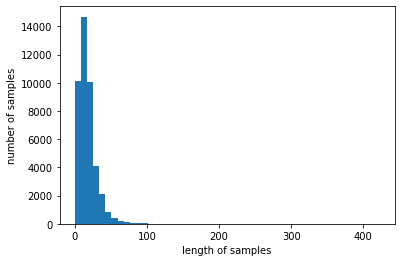

In [255]:
print('메시지의 최대 길이 :',max(len(l) for l in X_train))
print('메시지의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [256]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

below_threshold_len(50,X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 97.68821221744815


In [257]:
max_len = 50
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [258]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [259]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

In [260]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [261]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
536/536 [==============================] - ETA: 0s - loss: 0.6353 - acc: 0.6424
Epoch 00001: val_acc improved from -inf to 0.64915, saving model to best_model.h5
536/536 [==============================] - 80s 146ms/step - loss: 0.6353 - acc: 0.6424 - val_loss: 0.6191 - val_acc: 0.6492
Epoch 2/15
536/536 [==============================] - ETA: 0s - loss: 0.5306 - acc: 0.7322
Epoch 00002: val_acc improved from 0.64915 to 0.67694, saving model to best_model.h5
536/536 [==============================] - 79s 147ms/step - loss: 0.5306 - acc: 0.7322 - val_loss: 0.6207 - val_acc: 0.6769
Epoch 3/15
536/536 [==============================] - ETA: 0s - loss: 0.4646 - acc: 0.7765
Epoch 00003: val_acc did not improve from 0.67694
536/536 [==============================] - 78s 146ms/step - loss: 0.4646 - acc: 0.7765 - val_loss: 0.6268 - val_acc: 0.6622
Epoch 4/15
536/536 [==============================] - ETA: 0s - loss: 0.4092 - acc: 0.8102
Epoch 00004: val_acc did not improve from 0.676

In [262]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

335/335 [==============================] - 7s 19ms/step - loss: 0.6165 - acc: 0.6735

 테스트 정확도: 0.6735
